In [1]:
!nvidia-smi

Sat Oct 29 17:09:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0  On |                  N/A |
| 30%   38C    P0    63W / 260W |    518MiB / 11264MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import print_function
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainSet = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
testSet = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=50, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=50, shuffle=True, num_workers=2)

classNum = len(trainSet.classes)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = torchvision.models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(4096, classNum)
model = model.to(device)
# summary(model, (3, 32, 32))

/home/kelly/anaconda3/envs/cvdl/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/kelly/anaconda3/envs/cvdl/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
epoch = 30
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
lossFunc = nn.CrossEntropyLoss()

trainAcces, testAcces, losses = [], [], []

def saveModel():
    path = os.path.join(os.getcwd(), "model.pth")
    torch.save(model.state_dict(), path)
    
def testAccuracy():
    model.eval()
    correct = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)                    # predict
            _, predict = torch.max(outputs.data, 1)    # _: 預測機率最高的那類別的預測值; predict: 預測值最高的那個idx
            total += labels.size(0)                    # 只有最後一次 iteration，label.size(0) 可能不等於 batch size
            correct += (predict == labels).sum().item()  # 計算正確的個數
            
    accuracy = 100 * correct / total
    return accuracy

def train():
    print("Device:", device)
    bestAcc = 0.0
    
    for epochNum in range(epoch):
        correct, total, lossTotal = 0.0, 0, 0.0    # For predict
        for i, (images, labels) in enumerate(trainLoader, 0):
            # Get inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # Gradient
            optimizer.zero_grad()
            
            # Predict
            outputs = model(images)
            _, predict = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()
            
            # Compute
            loss = lossFunc(outputs, labels)
            lossTotal += loss.item()
            # Backpropagate
            loss.backward()
            # Adjust
            optimizer.step()

        # Compute and print the average accuracy
        testAcc = testAccuracy()
        testAcces.append(testAcc)
        
        trainAcc = 100 * correct / total
        trainAcces.append(trainAcc)
        
        lossAvg = lossTotal / total
        losses.append(lossAvg)
        
        print("Epoch num:", epochNum+1)
        print('the train accuracy is %d %%' % (trainAcc))
        print('the test accuracy is %d %%' % (testAcc))
        print('the loss is %.3f' % (lossAvg))
        print()

        # save model
        if testAcc > bestAcc:
            saveModel()
            bestAcc = testAcc
                
train()

Device: cuda:0
Epoch num: 1
the train accuracy is 19 %
the test accuracy is 23 %
the loss is 0.039

Epoch num: 2
the train accuracy is 31 %
the test accuracy is 39 %
the loss is 0.033

Epoch num: 3
the train accuracy is 40 %
the test accuracy is 45 %
the loss is 0.030

Epoch num: 4
the train accuracy is 47 %
the test accuracy is 55 %
the loss is 0.027

Epoch num: 5
the train accuracy is 59 %
the test accuracy is 62 %
the loss is 0.022

Epoch num: 6
the train accuracy is 66 %
the test accuracy is 66 %
the loss is 0.019

Epoch num: 7
the train accuracy is 71 %
the test accuracy is 72 %
the loss is 0.016

Epoch num: 8
the train accuracy is 75 %
the test accuracy is 74 %
the loss is 0.014

Epoch num: 9
the train accuracy is 78 %
the test accuracy is 74 %
the loss is 0.013

Epoch num: 10
the train accuracy is 80 %
the test accuracy is 76 %
the loss is 0.012

Epoch num: 11
the train accuracy is 82 %
the test accuracy is 78 %
the loss is 0.011

Epoch num: 12
the train accuracy is 83 %
the tes

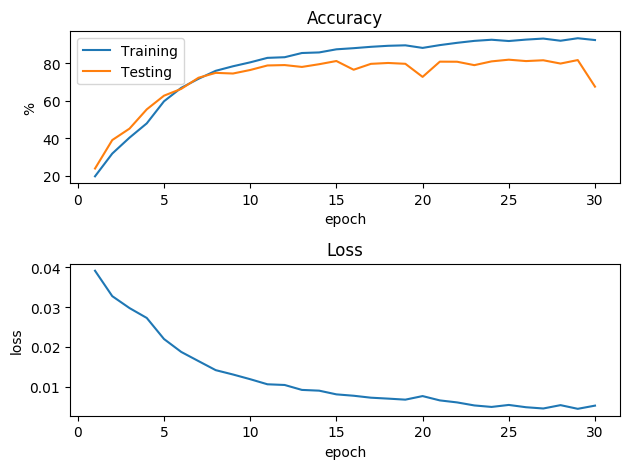

In [7]:
def plot(trainAcc, testAcc, loss):
    fig, axs = plt.subplots(2, 1)
    
    # Accuracy plt
    axs[0].set_title("Accuracy")
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("%")
    numLst = list( range(1, len(trainAcc)+1) )
    axs[0].plot(numLst, trainAcc, label="Training")
    axs[0].plot(numLst, testAcc, label="Testing")
    axs[0].legend()
    
    # Loss plt
    axs[1].set_title("Loss")
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("loss")
    numLst = list( range(1, len(loss)+1) )
    axs[1].plot(numLst, loss, label="loss")
    
    fig.tight_layout()
    plt.savefig("AccLoss.png")
    plt.show()
    
plot(trainAcces, testAcces, losses)